# CutMix, Mixup 비교실험
### 코드 진행
1. cutmix 함수 정의
2. mixup 함수 정의
3. augmentation 함수 정의
4. no augmentation, augmentation, aug+cutmix, aug+mixup의 4개의 데이터셋 구성
5. 각 데이터셋을 훈련할 resnet-50모델 정의
6. 훈련
7. 결과 시각화  
- 번외
    - augmentation 방법 시각화

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

### CutMix 함수 정의

In [2]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup 함수 정의

In [3]:
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### augmentation 및 데이터셋 정규화
- 증강에서는 좌우 랜덤 뒤집기와, 밝기 랜덤조절, hue랜덤 조절 사용

### 오류 이력
- 레이블을 원 핫 인코딩하는 부분에서 노드의 코드를 그대로 붙여넣었다가 데이터셋 레이블의 shape이 (none, 120, 120)이 되서 오류가 발생
- onehot이 2번 적용되어서 3차원 shape를 구성하는 문제
- 수정 전
```python
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
```
- 수정된 부분
```python
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
```

In [4]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # hue 랜덤 변경 추가
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    # augmentation 적용
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    # cutmix 적용
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    # mixup 적용
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    # 그 외 원핫 인코딩 적용
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

### 데이터셋 불러오기
- stanford_dogs를 사용했습니다.

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling stanford_dogs-train.tfrecord...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling stanford_dogs-test.tfrecord...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Dataset stanford_dogs downloaded and prepared to /aiffel/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


### 데이터셋 구성
- 순서대로 no augmentation, augmentation, aug+cutmix, aug+mixup

In [7]:
num_classes = ds_info.features["label"].num_classes

ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 모델 정의
- 4종의 각 데이터셋을 사용해 훈련할 모델 정의

In [6]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [7]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [8]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [9]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 훈련
- 학습률을 러프하게 조절해서 에폭과 학습률을 조정했습니다.
    - 큰 학습률 낮은 에폭으로 오버피팅 지점 확인
    - 더 낮은 학습률과 높은 에폭으로 상세 지점 확인
- lms에서와 달리 원핫 인코딩을 사용하여 categorical_crossentropy를 사용

In [11]:
EPOCH = 20

resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

/opt/conda/lib/python3.9/site-packages/keras/optimizer_v2/optimizer_v2.py:355: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/20
750/750 [==============================] - 204s 200ms/step - loss: 2.1932 - accuracy: 0.4491 - val_loss: 3.6018 - val_accuracy: 0.1713
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 0.7210 - accuracy: 0.7984 - val_loss: 1.1993 - val_accuracy: 0.6493
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.2316 - accuracy: 0.9523 - val_loss: 0.9424 - val_accuracy: 0.7238
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0641 - accuracy: 0.9942 - val_loss: 0.8874 - val_accuracy: 0.7422
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0288 - accuracy: 0.9987 - val_loss: 0.9434 - val_accuracy: 0.7330
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0170 - accuracy: 0.9994 - val_loss: 0.9130 - val_accuracy: 0.7430
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0118 - accuracy: 0.9998 - val_loss: 0.9218 -

In [12]:
del resnet50

aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 168s 205ms/step - loss: 2.3105 - accuracy: 0.4243 - val_loss: 2.7329 - val_accuracy: 0.3193
Epoch 2/20
750/750 [==============================] - 153s 204ms/step - loss: 1.0011 - accuracy: 0.7095 - val_loss: 1.2316 - val_accuracy: 0.6439
Epoch 3/20
750/750 [==============================] - 153s 204ms/step - loss: 0.5434 - accuracy: 0.8503 - val_loss: 1.0339 - val_accuracy: 0.6957
Epoch 4/20
750/750 [==============================] - 153s 204ms/step - loss: 0.3035 - accuracy: 0.9239 - val_loss: 1.0202 - val_accuracy: 0.7048
Epoch 5/20
750/750 [==============================] - 153s 204ms/step - loss: 0.1530 - accuracy: 0.9714 - val_loss: 1.0627 - val_accuracy: 0.7021
Epoch 6/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0895 - accuracy: 0.9876 - val_loss: 0.9974 - val_accuracy: 0.7283
Epoch 7/20
750/750 [==============================] - 153s 204ms/step - loss: 0.0591 - accuracy: 0.9922 - val_loss: 1.0659 -

In [13]:
del aug_resnet50

cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 176s 214ms/step - loss: 3.9078 - accuracy: 0.1952 - val_loss: 3.1373 - val_accuracy: 0.2346
Epoch 2/20
750/750 [==============================] - 161s 215ms/step - loss: 3.0603 - accuracy: 0.3930 - val_loss: 1.3443 - val_accuracy: 0.6178
Epoch 3/20
750/750 [==============================] - 165s 220ms/step - loss: 2.7804 - accuracy: 0.4798 - val_loss: 1.3326 - val_accuracy: 0.6221
Epoch 4/20
750/750 [==============================] - 155s 206ms/step - loss: 2.6142 - accuracy: 0.5341 - val_loss: 1.3290 - val_accuracy: 0.6313
Epoch 5/20
750/750 [==============================] - 157s 210ms/step - loss: 2.4662 - accuracy: 0.5802 - val_loss: 1.1636 - val_accuracy: 0.6678
Epoch 6/20
750/750 [==============================] - 158s 210ms/step - loss: 2.3629 - accuracy: 0.6156 - val_loss: 1.5021 - val_accuracy: 0.5978
Epoch 7/20
750/750 [==============================] - 158s 211ms/step - loss: 2.2420 - accuracy: 0.6522 - val_loss: 1.1228 -

In [14]:
del cutmix_resnet50

mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 171s 207ms/step - loss: 3.7771 - accuracy: 0.2267 - val_loss: 3.4765 - val_accuracy: 0.1878
Epoch 2/20
750/750 [==============================] - 155s 207ms/step - loss: 2.9673 - accuracy: 0.4390 - val_loss: 1.5365 - val_accuracy: 0.5709
Epoch 3/20
750/750 [==============================] - 155s 206ms/step - loss: 2.7346 - accuracy: 0.5238 - val_loss: 1.4327 - val_accuracy: 0.5974
Epoch 4/20
750/750 [==============================] - 159s 211ms/step - loss: 2.5638 - accuracy: 0.5878 - val_loss: 1.3739 - val_accuracy: 0.6188
Epoch 5/20
750/750 [==============================] - 172s 230ms/step - loss: 2.4172 - accuracy: 0.6425 - val_loss: 1.1971 - val_accuracy: 0.6627
Epoch 6/20
750/750 [==============================] - 154s 206ms/step - loss: 2.3343 - accuracy: 0.6762 - val_loss: 1.5058 - val_accuracy: 0.5969
Epoch 7/20
750/750 [==============================] - 155s 206ms/step - loss: 2.2515 - accuracy: 0.7092 - val_loss: 1.1570 -

### 결과 시각화

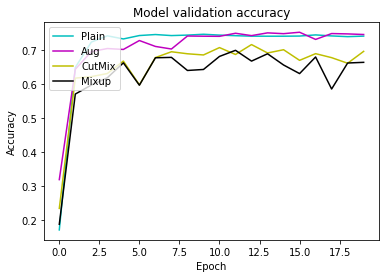

In [19]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Aug', 'CutMix', 'Mixup'], loc='upper left')
plt.show()

좀더 자세히 보기

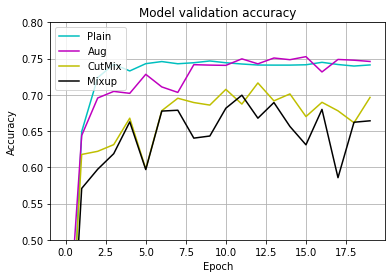

In [20]:
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'c')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'm')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'y')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain', 'Aug', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.5, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

### 실험 결과 회고
- 깜박하고 loss그래프를 못그려서 다시 그릴려고 했으나 훈련시간이 3시간이 걸려서 다 끝나고 다시 뽑아 보겠습니다.
- plain에서는 약 7~8에폭 정도에서 최적적합인것으로 보입니다.
- cutmix와 mixup, augmentation을 통해서 더 좋은 성능의 모델을 완성한다는 실험의 목표는 미충족 되었지만 에폭을 충분히 늘린다면 결과가 달라질 수 있을거 같습니다.
- accuracy만 봤을때는 cutmix와 mixup에서 학습이 아직 진행중인것으로 보이고 마찬가지로 augmentation에서도 아직 과대적합을 판단하기엔 이른거 같습니다.
- cutmix논문의 결과를 참고하면 약 150~200에폭을 넘어야 더 좋은 결과를 나타내는 모습을 확인할 수 있었습니다.
- 그래프가 크게 진동하고있는데 좀 더 복잡한 작업을 수행한 데이터에서 더 진동하는 모습을 보이고 있습니다.
    - 안정화 되기위해 아직 더 많은 에폭이 필요한것으로 보입니다.  

![이미지](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FubQXl%2Fbtq4X5W4tJI%2FGLPEh3VbFm6VOtbskQfsjK%2Fimg.png)
[참고 논문](https://openaccess.thecvf.com/content_ICCV_2019/papers/Yun_CutMix_Regularization_Strategy_to_Train_Strong_Classifiers_With_Localizable_Features_ICCV_2019_paper.pdf)

### 여러가지 augmentation

In [8]:
# 실험에서 사용한 augmentation
def augmentation(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    # hue 랜덤 변경 추가
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

(-0.5, 223.5, 223.5, -0.5)

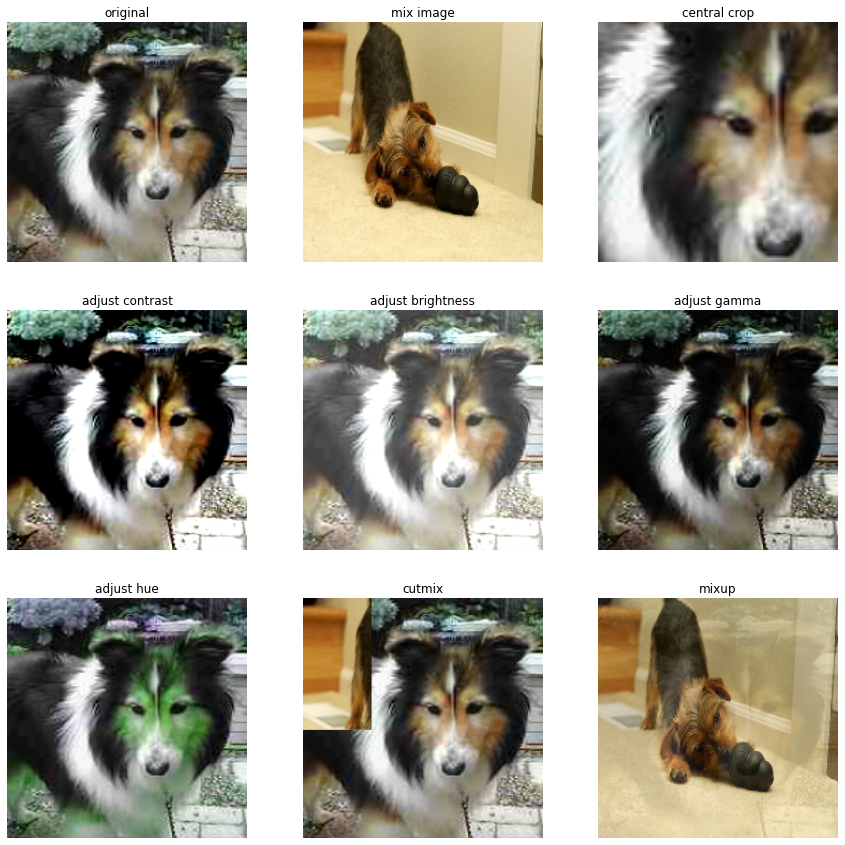

In [22]:
image, label = next(iter(ds_train.take(1)))
image_mix, label = next(iter(ds_train.take(1)))

# 이미지 크기 통일
image = tf.image.resize(image, [224, 224])
image_mix = tf.image.resize(image_mix, [224, 224])

# cutmix를 위한 범위설정
x_min, y_min, x_max, y_max = get_clip_box(image, image_mix)

# mixup
image = tf.cast(image, tf.float32)
image_mix = tf.cast(image_mix, tf.float32)

ratio = tf.random.uniform([], 0, 1)
mixup_image = (1-ratio)*image + ratio*image_mix

image = tf.cast(image, tf.uint8)
mixup_image = tf.cast(mixup_image, tf.uint8)
image_mix = tf.cast(image_mix, tf.uint8)

# 이미지 시각화
plt.figure(figsize=(15,15))

plt.subplot(3,3,1)
plt.title('original')
plt.imshow(image.numpy())
plt.axis('off')

plt.subplot(3,3,2)
plt.title('mix image')
plt.imshow(image_mix.numpy())
plt.axis('off')

plt.subplot(3,3,3)
plt.title('central crop')
plt.imshow(tf.image.central_crop(image, 0.5).numpy())
plt.axis('off')

plt.subplot(3,3,4)
plt.title('adjust contrast')
plt.imshow(tf.image.adjust_contrast(image, 1.5).numpy())
plt.axis('off')

plt.subplot(3,3,5)
plt.title('adjust brightness')
plt.imshow(tf.image.adjust_brightness(image, 0.2).numpy())
plt.axis('off')

plt.subplot(3,3,6)
plt.title('adjust gamma')
plt.imshow(tf.image.adjust_gamma(image, gamma=1.5).numpy())
plt.axis('off')

plt.subplot(3,3,7)
plt.title('adjust hue')
plt.imshow(tf.image.adjust_hue(image, delta=0.2).numpy())
plt.axis('off')

plt.subplot(3,3,8)
plt.title('cutmix')
plt.imshow(mix_2_images(image, image_mix, x_min, y_min, x_max, y_max).numpy())
plt.axis('off')

plt.subplot(3,3,9)
plt.title('mixup')
plt.imshow(mixup_image.numpy())
plt.axis('off')

### 회고
- 여러가지 augmentation방법들이 있지만 이번 실험에서 좌우 반전, 밝기 조절, hue조절을 선택한 이유에 대해 설명하겠습니다.
    - 좌우 반전은 위상 변화 관점에서 모델에 새로운 이미지를 학습시킬 수 있다고 생각해서 추가했습니다. 마찬가지 이유로 위아래 반전, 회전 또한 비슷한 정도의 효과를 보일것이라고 추정합니다.
    - 밝기 조절은 픽셀값의 단순 상수차를 학습시키기에 좋다고 생각해서 추가하게 되었습니다. 비슷한 경우를 위해 contrast를 통해 픽셀값의 상수비를 학습시킬 수 있다고 생각합니다.
    - hue조절을 통해 rgb색 채널간의 관계를 학습시키기 위해 추가하였습니다. hue를 조절하면 색의 종류가 바뀌게 됩니다. 이를 통해 다른 채널에서의 관계도 학습시킬 수 있다고 추정했습니다.
    - 하지만 이런 augmentation을 주의해서 사용해야 할 필요성 또한 느꼈습니다. 라벨링에서 에러를 더하게 될 수도 있다고 생각했습니다.
        - 예를들어 상한 과일을 찾는 task를 생각해 보면 일반적으로 상한 음식의 경우 색이 변질되는 경우가 자주 발생합니다. 이런 경우의 학습에서 hue조절이나 밝기조절등을 통해 색감이 변질되게 된다면 augmentation이 결과적으로 오류에 크게 기여할 것이라고 보여집니다.
        - 이번 task에서는 색이 좀 바뀌더라도 강아지의 종이 바뀌지는 않기 때문에 hue와 밝기 조절을 사용하였습니다.  
        

- cutmix에서 위의 예시를 보듯 강아지와 거의 상관없는 부분이 붙여저서 강아지로 라벨링이 주장되고 있습니다. 실제와 라벨링의 차이가 큰 경우 의미없는 라벨링의 에러를 더하게 될 가능성이 크다고 생각했습니다. 이를 해결하기 위해...
    - 시멘틱 세그멘테이션을 통해 잘려진 이미지에서 실제 강아지가 잘려진 비율을 고려해 라벨링을 수정할 수 있습니다.
        - 하지만 더 복잡한 모델을 사용해야하고 모델을 사용하기 위해 다른 모델을 사용해야 한다는 부분이 부자연스럽습니다.
    - 이미지 데이터에서 대개 핵심적인 부분은 중앙에 모여있는 경향이 있습니다. 이를 참고하여 중앙에 가까운 부분이 붙여진 경우 더 높은 라벨링 숫자를 가지게 한다면 더 정확한 라벨링을 부여할 수 있다고 생각합니다. 이를 위해서 정규분포를 사용할 수 있습니다. 중앙에서의 픽셀까지 거리를 기준으로 하여 정규분포를 통해 가중치를 곱해 라벨링을 진행한다면 cutmix에서 더욱 의미있는 라벨링을 할 수 있다고 생각합니다.